<a href="https://colab.research.google.com/github/mitkrieg/dl-assignment-1/blob/main/assignment1_practical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 1: DL Basics

### Goal
Implement [LeNet5](https://arxiv.org/pdf/1502.03167v3) and compare various regularization techniques on the network using the FashionMNSIT dataset.

## Library Imports

In [1]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import itertools
from time import time
# from google.colab import drive
import gzip
import typing as T
import wandb

# drive.mount('/content/drive')
torch.manual_seed(123)

wandb.login()

# wandb.init(project='DL_Assignment_1')


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mitkrieger (mitkrieger-cornell-university). Use `wandb login --relogin` to force relogin


True

## Check for GPU Access

In [2]:
print("------ ACCELERATION INFO -----")
print('CUDA GPU Available:',torch.cuda.is_available())
print('MPS GPU Available:', torch.backends.mps.is_available())
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('GPU Name:',torch.cuda.get_device_name(0))
  print('GPU Count:',torch.cuda.device_count())
  print('GPU Memory Allocated:',torch.cuda.memory_allocated(0))
  print('GPU Memory Cached:',torch.cuda.memory_reserved(0))
# elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
#   device = torch.device('mps')
#   print('Pytorch GPU Build:',torch.backends.mps.is_built())
else:
  device = torch.device('cpu')
  print('Using CPU')

------ ACCELERATION INFO -----
CUDA GPU Available: False
MPS GPU Available: True
Using CPU


## Load Data using Pytorch

In [17]:
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -P ./data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -P ./data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -P ./data
!wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -P ./data

--2024-09-11 22:09:38--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 3.5.135.60, 3.5.134.100, 52.219.171.224, ...
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|3.5.135.60|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘./data/train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]  25.20M  5.06MB/s    in 6.8s    

2024-09-11 22:09:46 (3.70 MB/s) - ‘./data/train-images-idx3-ubyte.gz’ saved [26421880/26421880]



In [3]:

# PATH = '/content/drive/MyDrive/Fall 2024/Deep Learning/Assignment 1/data'
PATH = './data'


### Define FashionMNIST

In [4]:
class FasionMNISTDataset(Dataset):
  def __init__(self, path: str, kind: str, transform=None, target_transform=None, device=None) -> None:
    self.transform = transform
    self.target_transform = target_transform
    self.device = device
    self.labels, self.images = self._load_data(path, kind)

  def _load_data(self, path: str, kind: str) -> T.Tuple[np.ndarray, np.ndarray]:
    with gzip.open(path + f'/{kind}-labels-idx1-ubyte.gz', 'rb') as lable_file:
      lbls = np.frombuffer(lable_file.read(), dtype=np.int8, offset=8)
      lbls = np.copy(lbls)
    with gzip.open(path + f'/{kind}-images-idx3-ubyte.gz', 'rb') as lable_file:
      imgs = np.frombuffer(lable_file.read(), dtype=np.uint8, offset=16).reshape(len(lbls), 1, 28, 28)
      imgs = (np.copy(imgs) / 255).astype(np.float32)
    return lbls, imgs

  def __len__(self) -> int:
    return self.labels.size

  def __getitem__(self, index: int) -> T.Tuple[torch.tensor, torch.tensor]:
    label = torch.tensor(self.labels[index], dtype=torch.long)
    img = torch.tensor(self.images[index])
    if self.device:
      img = img.to(self.device)
      label = label.to(self.device)
    if self.target_transform:
      label = self.target_transform(label)
    if self.transform:
      img = self.transform(img)


    return img, label

def show_img(dataset: Dataset, index: int) -> None:
  img, label = dataset[index]
  labels_map = {
            0: "T-Shirt",
            1: "Trouser",
            2: "Pullover",
            3: "Dress",
            4: "Coat",
            5: "Sandal",
            6: "Shirt",
            7: "Sneaker",
            8: "Bag",
            9: "Ankle Boot",
        }
  plt.imshow(img.cpu().reshape(28,28), cmap='gray')
  plt.title(labels_map[label.cpu().item()])
  plt.show()

### Create Train, Validation and Test sets with loaders

In [5]:
gen = torch.Generator().manual_seed(123)

train = FasionMNISTDataset(PATH, 'train', device=device)
train, val = torch.utils.data.random_split(train, [0.8, 0.2], generator=gen)
test = FasionMNISTDataset(PATH, 'test', device=device)

batch = 128
trainloader = DataLoader(train, batch, shuffle=True, generator=gen)
valloader = DataLoader(val, batch, shuffle=True, generator=gen)
testloader = DataLoader(test, batch, shuffle=True, generator=gen)

dataloaders = {
    'train': trainloader,
    'val': valloader,
    'test': testloader
}

#### Example Image

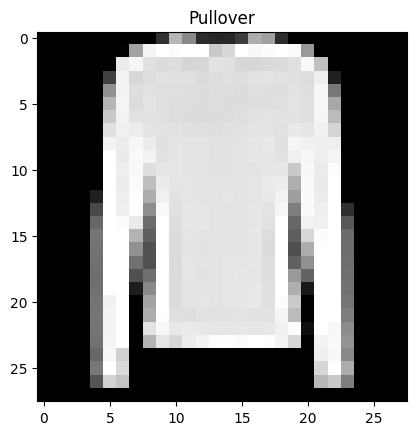

In [6]:
show_img(train, 0)

## LeNet5

In [7]:
class Lenet5(nn.Module):
  def __init__(self, **kwargs):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
    self.max_pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
    self.max_pool2 = nn.MaxPool2d(2, 2)
    self.fc1 = nn.Linear(16*4*4, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84,10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

### Define Training Loop

In [12]:


def train_epoch(network, dataloader, loss_fn, optimizer, device, epoch, verbosity: int):
  """Train one epoch of a Lenet5 network"""
  network.train()
  batch_loss = 0
  total_loss = 0

  # iterate over all batches
  for i, data in enumerate(dataloader):
    inputs, labels = data

    optimizer.zero_grad()
    outputs = network(inputs)
    loss = loss_fn(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    batch_loss += loss.item()
    if i % verbosity == verbosity - 1:
      print(f'Batch #{i + 1} Loss: {batch_loss / verbosity}')
      batch_loss = 0

  total_loss = 0

def eval_network(title, network, dataloader, loss_fn, epoch):
  """Evaluate model and log metrics to wandb"""
  network.eval()
  correct = 0
  total = 0
  loss = 0

  with torch.no_grad():
      for data in dataloader:
          images, labels = data
          outputs = network(images)
          _, predicted = torch.max(outputs.data, 1)

          loss += loss_fn(outputs, labels)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = correct / total
      wandb.log({
          f'{title}-loss': loss / len(dataloader),
          f'{title}-accuracy': accuracy
      }, step=epoch)
  
  print(f'\033[92m{title} accuracy: {correct}/{total} = {100 * accuracy : .4} % ||| loss {loss / len(dataloader)}\033[0m')
  return accuracy

def train_network(network, dataloaders, loss_fn, optimizer, device, epochs: int, verbosity: int):
  """Train network for given number of epochs using optimizer and loss_fn"""
  train_accuracy, val_accuracy, test_accuracy = 0, 0, 0
  for epoch in range(epochs):
    print(f'----------- Epoch #{epoch + 1} ------------')
    train_epoch(network, dataloaders['train'], loss_fn, optimizer, device, epoch, verbosity)
    train_accuracy = eval_network('Train', network, dataloaders['train'], loss_fn, epoch)
    val_accuracy = eval_network('Validation', network, dataloaders['val'], loss_fn, epoch)    
    test_accuracy = eval_network('Test', network, dataloaders['test'], loss_fn, epoch)
    print('------------------------------------\n')
  print('----------- Train Complete! ------------')
  return {
    "train":train_accuracy,
    "val":val_accuracy,
    "test":test_accuracy,
  }


def hyperparameter_tuning(network_cls, dataloaders, device, epochs: int, **kwargs):
  """Train multiple networks and print out hyperparameters & metrics for the highest performing model based on validation accuracy"""
  ts = time()
  keys = kwargs.keys()
  best_model = None
  for i, v in enumerate(itertools.product(*kwargs.values())):
    hyperparams = dict(zip(keys, v))
    network = network_cls(**hyperparams)
    network.to(device)
    name = network._get_name() + '_' + str(ts) + '_' + str(i)
    run = wandb.init(
      id=name,
      config={
        **hyperparams
      }
    )

    print(f'XXXXXXXX Tuning Network {network._get_name()} XXXXXXXXX')
    print('Hyperparameter Config:',hyperparams)

    cross_entropy = nn.CrossEntropyLoss()
    sgd = optim.SGD(
      network.parameters(), 
      lr=hyperparams['learning_rate'], 
      momentum=hyperparams['momentum'],
      weight_decay=hyperparams.get('weight_decay',0)
    )
      
    accuracies = train_network(network, dataloaders, cross_entropy, sgd, device, epochs, 100)
    run.finish(quiet=True)
    if best_model is None:
      best_model = {'net':network, "accuracy":accuracies, "name":name}
    elif best_model['accuracy']['val'] < accuracies['val']:
      best_model = {'net':network, "accuracy":accuracies, "name":name}
  print('\033[93m!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!\033[0m')
  print(f'Best Model: {best_model['net']}\nwandb name: {best_model['name']}\n\nHyperParams: {hyperparams}\n\nAccuracies: {best_model['accuracy']}')
  return best_model
  


### Train Lenet5

In [8]:

param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7]
}

best_lenet = hyperparameter_tuning(Lenet5, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.0236032807827
Batch #200 Loss: 1.082595824599266
Batch #300 Loss: 0.8314408749341965
Train accuracy: 35359/48000 =  73.66 % ||| loss 0.678673267364502
Validation accuracy: 8811/12000 =  73.42 % ||| loss 0.6751672625541687
Test accuracy: 7338/10000 =  73.38 % ||| loss 0.6999877691268921
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6678355169296265
Batch #200 Loss: 0.6359583994746209
Batch #300 Loss: 0.587376599907875
Train accuracy: 38047/48000 =  79.26 % ||| loss 0.5283836126327515
Validation accuracy: 9546/12000 =  79.55 % ||| loss 0.5270049571990967
Test accuracy: 7833/10000 =  78.33 % ||| loss 0.5533502101898193
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5336186403036117
Batch #200 Loss: 0.5252243930101395
Batch #300 Loss: 0.4805790835618

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.372236957550049
Batch #200 Loss: 1.44293381690979
Batch #300 Loss: 0.9303632396459579
Train accuracy: 33756/48000 =  70.33 % ||| loss 0.7710257768630981
Validation accuracy: 8450/12000 =  70.42 % ||| loss 0.7680749297142029
Test accuracy: 6980/10000 =  69.8 % ||| loss 0.786946713924408
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7766092491149902
Batch #200 Loss: 0.7097075185179711
Batch #300 Loss: 0.6585011348128319
Train accuracy: 35088/48000 =  73.1 % ||| loss 0.7028211355209351
Validation accuracy: 8776/12000 =  73.13 % ||| loss 0.7087828516960144
Test accuracy: 7210/10000 =  72.1 % ||| loss 0.7435469031333923
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6134333011507987
Batch #200 Loss: 0.6108840742707252
Batch #300 Loss: 0.595069390535

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 1.8289011430740356
Batch #200 Loss: 0.7458706274628639
Batch #300 Loss: 0.5978384116291999
Train accuracy: 38414/48000 =  80.03 % ||| loss 0.5146629810333252
Validation accuracy: 9601/12000 =  80.01 % ||| loss 0.5180776119232178
Test accuracy: 7913/10000 =  79.13 % ||| loss 0.5339449048042297
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.4971723836660385
Batch #200 Loss: 0.47286322206258774
Batch #300 Loss: 0.45380102187395094
Train accuracy: 41032/48000 =  85.48 % ||| loss 0.39086923003196716
Validation accuracy: 10211/12000 =  85.09 % ||| loss 0.39998525381088257
Test accuracy: 8372/10000 =  83.72 % ||| loss 0.4256141185760498
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.40971171140670776
Batch #200 Loss: 0.37996457308530807
Batch #300 Loss: 

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3004798316955566
Batch #200 Loss: 2.298731439113617
Batch #300 Loss: 2.2958174967765808
Train accuracy: 6002/48000 =  12.5 % ||| loss 2.2887251377105713
Validation accuracy: 1490/12000 =  12.42 % ||| loss 2.2890238761901855
Test accuracy: 1211/10000 =  12.11 % ||| loss 2.2887988090515137
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.283385207653046
Batch #200 Loss: 2.2627668452262877
Batch #300 Loss: 2.1845869207382203
Train accuracy: 22398/48000 =  46.66 % ||| loss 1.6309734582901
Validation accuracy: 5580/12000 =  46.5 % ||| loss 1.630801796913147
Test accuracy: 4633/10000 =  46.33 % ||| loss 1.6331158876419067
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.3403572070598602
Batch #200 Loss: 1.06612733066082
Batch #300 Loss: 1.0087201648950577


XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2647216057777406
Batch #200 Loss: 1.1113633871078492
Batch #300 Loss: 0.8174711203575135
Train accuracy: 35496/48000 =  73.95 % ||| loss 0.7023919820785522
Validation accuracy: 8876/12000 =  73.97 % ||| loss 0.6963402032852173
Test accuracy: 7346/10000 =  73.46 % ||| loss 0.7198643088340759
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6721812948584557
Batch #200 Loss: 0.6212318435311317
Batch #300 Loss: 0.5913525414466858
Train accuracy: 38477/48000 =  80.16 % ||| loss 0.5213927626609802
Validation accuracy: 9638/12000 =  80.32 % ||| loss 0.5202727317810059
Test accuracy: 7967/10000 =  79.67 % ||| loss 0.5518684983253479
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5416123470664025
Batch #200 Loss: 0.5025940489768982
Batch #300 Loss: 0.4940

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302157437801361
Batch #200 Loss: 2.2958237099647523
Batch #300 Loss: 2.2803567123413084
Train accuracy: 22502/48000 =  46.88 % ||| loss 1.9492415189743042
Validation accuracy: 5622/12000 =  46.85 % ||| loss 1.9476317167282104
Test accuracy: 4682/10000 =  46.82 % ||| loss 1.9506611824035645
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.2308168429136277
Batch #200 Loss: 0.874534747004509
Batch #300 Loss: 0.7926766461133957
Train accuracy: 34692/48000 =  72.28 % ||| loss 0.7441235184669495
Validation accuracy: 8737/12000 =  72.81 % ||| loss 0.72735196352005
Test accuracy: 7223/10000 =  72.23 % ||| loss 0.7577136754989624
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6893545997142791
Batch #200 Loss: 0.6657565227150917
Batch #300 Loss: 0.64464891

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303585147857666
Batch #200 Loss: 2.3025809073448182
Batch #300 Loss: 2.3018727898597717
Train accuracy: 5524/48000 =  11.51 % ||| loss 2.301271915435791
Validation accuracy: 1408/12000 =  11.73 % ||| loss 2.3016414642333984
Test accuracy: 1154/10000 =  11.54 % ||| loss 2.3014867305755615
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3011486458778383
Batch #200 Loss: 2.300493266582489
Batch #300 Loss: 2.2998646783828733
Train accuracy: 6972/48000 =  14.52 % ||| loss 2.2995645999908447
Validation accuracy: 1758/12000 =  14.65 % ||| loss 2.299929618835449
Test accuracy: 1463/10000 =  14.63 % ||| loss 2.2996625900268555
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2989095425605774
Batch #200 Loss: 2.2992150592803955
Batch #300 Loss: 2.29857273101

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302724525928497
Batch #200 Loss: 2.300033738613129
Batch #300 Loss: 2.297971234321594
Train accuracy: 5282/48000 =  11.0 % ||| loss 2.292156457901001
Validation accuracy: 1290/12000 =  10.75 % ||| loss 2.2919869422912598
Test accuracy: 1106/10000 =  11.06 % ||| loss 2.292065382003784
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.288941659927368
Batch #200 Loss: 2.2780629539489747
Batch #300 Loss: 2.2525090527534486
Train accuracy: 9795/48000 =  20.41 % ||| loss 2.1421713829040527
Validation accuracy: 2445/12000 =  20.38 % ||| loss 2.1407570838928223
Test accuracy: 2071/10000 =  20.71 % ||| loss 2.1427695751190186
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.9687795078754424
Batch #200 Loss: 1.356781769990921
Batch #300 Loss: 1.0547279751300

XXXXXXXX Tuning Network Lenet5 XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.305977053642273
Batch #200 Loss: 2.3043637681007385
Batch #300 Loss: 2.303945231437683
Train accuracy: 4787/48000 =  9.973 % ||| loss 2.303093671798706
Validation accuracy: 1213/12000 =  10.11 % ||| loss 2.303616523742676
Test accuracy: 1004/10000 =  10.04 % ||| loss 2.3035027980804443
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3025988864898683
Batch #200 Loss: 2.3015040445327757
Batch #300 Loss: 2.3017877030372618
Train accuracy: 6566/48000 =  13.68 % ||| loss 2.299900770187378
Validation accuracy: 1674/12000 =  13.95 % ||| loss 2.3004066944122314
Test accuracy: 1384/10000 =  13.84 % ||| loss 2.30014705657959
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2988584542274477
Batch #200 Loss: 2.2980621576309206
Batch #300 Loss: 2.297765119075

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7}

Accuracies: {'train': 0.9225208333333333, 'val': 0.8955833333333333, 'test': 0.8912}


### Variations on LeNet5

#### Using Batch Normalization

In [10]:
class Lenet5BN(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.BN1 = nn.BatchNorm2d(6)
        self.BN2 = nn.BatchNorm2d(16)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(self.BN1(x))
        x = self.max_pool1(x)
        x = self.conv2(x)
        x = F.relu(self.BN2(x))
        x = self.max_pool2(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7]
}

best_batchnorm = hyperparameter_tuning(Lenet5BN, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 1.0918693089485167
Batch #200 Loss: 0.5731843969225884
Batch #300 Loss: 0.4882547771930695
Train accuracy: 40554/48000 =  84.49 % ||| loss 0.4308229088783264
Validation accuracy: 10138/12000 =  84.48 % ||| loss 0.4348497986793518
Test accuracy: 8345/10000 =  83.45 % ||| loss 0.45388683676719666
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.428620548248291
Batch #200 Loss: 0.39510360807180406
Batch #300 Loss: 0.38443693801760676
Train accuracy: 41434/48000 =  86.32 % ||| loss 0.37690454721450806
Validation accuracy: 10326/12000 =  86.05 % ||| loss 0.38144558668136597
Test accuracy: 8508/10000 =  85.08 % ||| loss 0.4072236120700836
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.3621974065899849
Batch #200 Loss: 0.3631885758042335
Batch #300 Loss: 0

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 0.9935321161150932
Batch #200 Loss: 0.5134154757857323
Batch #300 Loss: 0.46340573489665987
Train accuracy: 41022/48000 =  85.46 % ||| loss 0.3874186873435974
Validation accuracy: 10209/12000 =  85.08 % ||| loss 0.3985355496406555
Test accuracy: 8462/10000 =  84.62 % ||| loss 0.40989941358566284
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.38847166270017625
Batch #200 Loss: 0.37721108555793764
Batch #300 Loss: 0.3552295814454556
Train accuracy: 42001/48000 =  87.5 % ||| loss 0.33719897270202637
Validation accuracy: 10414/12000 =  86.78 % ||| loss 0.3544819951057434
Test accuracy: 8645/10000 =  86.45 % ||| loss 0.3721124231815338
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.3348969057202339
Batch #200 Loss: 0.34726156026124955
Batch #300 Loss

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 0.8562760981917381
Batch #200 Loss: 0.48960247814655306
Batch #300 Loss: 0.43837496876716614
Train accuracy: 41177/48000 =  85.79 % ||| loss 0.39201444387435913
Validation accuracy: 10246/12000 =  85.38 % ||| loss 0.39783498644828796
Test accuracy: 8474/10000 =  84.74 % ||| loss 0.4265286326408386
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.3823950935900211
Batch #200 Loss: 0.3470021843910217
Batch #300 Loss: 0.36385163575410845
Train accuracy: 42408/48000 =  88.35 % ||| loss 0.31451764702796936
Validation accuracy: 10527/12000 =  87.72 % ||| loss 0.33332669734954834
Test accuracy: 8745/10000 =  87.45 % ||| loss 0.349338561296463
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.3245084962248802
Batch #200 Loss: 0.3297124974429607
Batch #300 Los

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.178512649536133
Batch #200 Loss: 1.6742618155479432
Batch #300 Loss: 1.1257507419586181
Train accuracy: 33938/48000 =  70.7 % ||| loss 0.8377549052238464
Validation accuracy: 8494/12000 =  70.78 % ||| loss 0.8317321538925171
Test accuracy: 7006/10000 =  70.06 % ||| loss 0.8460841178894043
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7902303844690323
Batch #200 Loss: 0.7069436472654342
Batch #300 Loss: 0.661941009759903
Train accuracy: 36908/48000 =  76.89 % ||| loss 0.6139974594116211
Validation accuracy: 9275/12000 =  77.29 % ||| loss 0.6110281348228455
Test accuracy: 7652/10000 =  76.52 % ||| loss 0.6254181861877441
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6125414207577705
Batch #200 Loss: 0.5672504484653473
Batch #300 Loss: 0.5577205

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 1.30896819293499
Batch #200 Loss: 0.5895030754804611
Batch #300 Loss: 0.4996562898159027
Train accuracy: 40278/48000 =  83.91 % ||| loss 0.44084054231643677
Validation accuracy: 10002/12000 =  83.35 % ||| loss 0.44378170371055603
Test accuracy: 8326/10000 =  83.26 % ||| loss 0.4650436043739319
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.4197103378176689
Batch #200 Loss: 0.40751411974430085
Batch #300 Loss: 0.3823903886973858
Train accuracy: 40532/48000 =  84.44 % ||| loss 0.4289611876010895
Validation accuracy: 10071/12000 =  83.93 % ||| loss 0.44394201040267944
Test accuracy: 8349/10000 =  83.49 % ||| loss 0.4665185511112213
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.3719278936088085
Batch #200 Loss: 0.34727256596088407
Batch #300 Loss:

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 1.796340789794922
Batch #200 Loss: 0.8401311552524566
Batch #300 Loss: 0.6155732488632202
Train accuracy: 38417/48000 =  80.04 % ||| loss 0.527275025844574
Validation accuracy: 9600/12000 =  80.0 % ||| loss 0.5297437906265259
Test accuracy: 7912/10000 =  79.12 % ||| loss 0.5499461889266968
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5073026782274246
Batch #200 Loss: 0.46626132547855376
Batch #300 Loss: 0.45285633862018587
Train accuracy: 40895/48000 =  85.2 % ||| loss 0.41250696778297424
Validation accuracy: 10193/12000 =  84.94 % ||| loss 0.4225658178329468
Test accuracy: 8412/10000 =  84.12 % ||| loss 0.43962860107421875
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.4092708374559879
Batch #200 Loss: 0.4076686878502369
Batch #300 Loss: 0.4

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2856762337684633
Batch #200 Loss: 2.2634411692619323
Batch #300 Loss: 2.2426475882530212
Train accuracy: 17902/48000 =  37.3 % ||| loss 2.2114834785461426
Validation accuracy: 4466/12000 =  37.22 % ||| loss 2.212064266204834
Test accuracy: 3734/10000 =  37.34 % ||| loss 2.2115838527679443
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.19739305973053
Batch #200 Loss: 2.1695296812057494
Batch #300 Loss: 2.132632248401642
Train accuracy: 20042/48000 =  41.75 % ||| loss 2.084836483001709
Validation accuracy: 4962/12000 =  41.35 % ||| loss 2.086228132247925
Test accuracy: 4183/10000 =  41.83 % ||| loss 2.087036609649658
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.060846166610718
Batch #200 Loss: 2.0173727893829345
Batch #300 Loss: 1.971383795738

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9}
----------- Epoch #1 ------------
Batch #100 Loss: 2.222204394340515
Batch #200 Loss: 1.8380243360996247
Batch #300 Loss: 1.3198363387584686
Train accuracy: 34001/48000 =  70.84 % ||| loss 0.9408679008483887
Validation accuracy: 8543/12000 =  71.19 % ||| loss 0.9314034581184387
Test accuracy: 7023/10000 =  70.23 % ||| loss 0.95041823387146
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.8804208594560623
Batch #200 Loss: 0.7651836723089218
Batch #300 Loss: 0.6939000529050827
Train accuracy: 36773/48000 =  76.61 % ||| loss 0.6390272378921509
Validation accuracy: 9264/12000 =  77.2 % ||| loss 0.6321969628334045
Test accuracy: 7618/10000 =  76.18 % ||| loss 0.6482226848602295
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6246786054968834
Batch #200 Loss: 0.5924420538544655
Batch #300 Loss: 0.55983

XXXXXXXX Tuning Network Lenet5BN XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2615723252296447
Batch #200 Loss: 2.171421525478363
Batch #300 Loss: 2.0518499886989594
Train accuracy: 22505/48000 =  46.89 % ||| loss 1.8355486392974854
Validation accuracy: 5580/12000 =  46.5 % ||| loss 1.8366438150405884
Test accuracy: 4692/10000 =  46.92 % ||| loss 1.8385438919067383
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.7264230811595918
Batch #200 Loss: 1.5149186956882477
Batch #300 Loss: 1.3231341862678527
Train accuracy: 32676/48000 =  68.08 % ||| loss 1.1481695175170898
Validation accuracy: 8213/12000 =  68.44 % ||| loss 1.1448118686676025
Test accuracy: 6805/10000 =  68.05 % ||| loss 1.1514519453048706
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.0863224810361862
Batch #200 Loss: 1.0026645022630691
Batch #300 Loss: 0.928

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5BN(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (BN1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (BN2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7}

Accuracies: {'train': 0.9527083333333334, 'val': 0.90675, 'test': 0.9002}


#### Using Dropout

In [11]:
class Lenet5Dropout(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.dropout = nn.Dropout(kwargs['dropout'])

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.max_pool1(x)
        x = F.relu(self.conv2(x))
        x = self.max_pool1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x
    
param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7],
  'dropout':[0.2, 0.35, 0.5]
}

best_dropout = hyperparameter_tuning(Lenet5Dropout, dataloaders, device, 25, **param_grid)

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2967526865005494
Batch #200 Loss: 1.6814701330661774
Batch #300 Loss: 1.0656963312625884
Train accuracy: 33596/48000 =  69.99 % ||| loss 0.7606455087661743
Validation accuracy: 8359/12000 =  69.66 % ||| loss 0.7571238875389099
Test accuracy: 6902/10000 =  69.02 % ||| loss 0.7858148217201233
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7927420252561569
Batch #200 Loss: 0.7378638511896134
Batch #300 Loss: 0.6641693717241287
Train accuracy: 37419/48000 =  77.96 % ||| loss 0.5708009600639343
Validation accuracy: 9354/12000 =  77.95 % ||| loss 0.5666521191596985
Test accuracy: 7704/10000 =  77.04 % ||| loss 0.5867547392845154
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6134250581264495
Batch #200 Loss: 0.6039151301980019
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.1879753601551055
Batch #200 Loss: 1.3221731489896775
Batch #300 Loss: 1.0395991057157516
Train accuracy: 34462/48000 =  71.8 % ||| loss 0.7476757168769836
Validation accuracy: 8599/12000 =  71.66 % ||| loss 0.7422230243682861
Test accuracy: 7111/10000 =  71.11 % ||| loss 0.7632440328598022
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7998095852136612
Batch #200 Loss: 0.7632695233821869
Batch #300 Loss: 0.699059984087944
Train accuracy: 36299/48000 =  75.62 % ||| loss 0.6148649454116821
Validation accuracy: 9031/12000 =  75.26 % ||| loss 0.6171642541885376
Test accuracy: 7519/10000 =  75.19 % ||| loss 0.6364995837211609
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6414203995466232
Batch #200 Loss: 0.6058100196719169
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2540293633937836
Batch #200 Loss: 1.5027018976211548
Batch #300 Loss: 1.1650890809297563
Train accuracy: 32477/48000 =  67.66 % ||| loss 0.8160099983215332
Validation accuracy: 8144/12000 =  67.87 % ||| loss 0.8034597635269165
Test accuracy: 6712/10000 =  67.12 % ||| loss 0.8245924115180969
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.8885250771045685
Batch #200 Loss: 0.831328312754631
Batch #300 Loss: 0.7726940184831619
Train accuracy: 36072/48000 =  75.15 % ||| loss 0.6241834759712219
Validation accuracy: 9064/12000 =  75.53 % ||| loss 0.6146882772445679
Test accuracy: 7436/10000 =  74.36 % ||| loss 0.640768826007843
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.700551832318306
Batch #200 Loss: 0.6824092841148377
Batch 

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 1.4171263074874878
Batch #200 Loss: 0.6999848559498787
Batch #300 Loss: 0.6068363869190216
Train accuracy: 38884/48000 =  81.01 % ||| loss 0.5040724873542786
Validation accuracy: 9750/12000 =  81.25 % ||| loss 0.49646463990211487
Test accuracy: 8039/10000 =  80.39 % ||| loss 0.5267516374588013
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5058696463704109
Batch #200 Loss: 0.47221211552619935
Batch #300 Loss: 0.48788372963666915
Train accuracy: 40786/48000 =  84.97 % ||| loss 0.39612239599227905
Validation accuracy: 10204/12000 =  85.03 % ||| loss 0.3982788920402527
Test accuracy: 8441/10000 =  84.41 % ||| loss 0.42216649651527405
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.46104108184576037
Batch #200 Loss: 0.43130232304

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 1.6171752208471297
Batch #200 Loss: 0.777950463294983
Batch #300 Loss: 0.685126773416996
Train accuracy: 38133/48000 =  79.44 % ||| loss 0.5164974927902222
Validation accuracy: 9586/12000 =  79.88 % ||| loss 0.5152369737625122
Test accuracy: 7830/10000 =  78.3 % ||| loss 0.5371954441070557
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5914046880602837
Batch #200 Loss: 0.5618526414036751
Batch #300 Loss: 0.5472726196050643
Train accuracy: 39803/48000 =  82.92 % ||| loss 0.4438246190547943
Validation accuracy: 9948/12000 =  82.9 % ||| loss 0.44593846797943115
Test accuracy: 8191/10000 =  81.91 % ||| loss 0.4679599702358246
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.521308706998825
Batch #200 Loss: 0.524477511048317
Batch

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 1.6412147665023804
Batch #200 Loss: 0.9084899467229843
Batch #300 Loss: 0.7720858246088028
Train accuracy: 36993/48000 =  77.07 % ||| loss 0.5932733416557312
Validation accuracy: 9231/12000 =  76.92 % ||| loss 0.5937412977218628
Test accuracy: 7608/10000 =  76.08 % ||| loss 0.6149501800537109
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.672717048227787
Batch #200 Loss: 0.6499810868501663
Batch #300 Loss: 0.6248873081803322
Train accuracy: 40033/48000 =  83.4 % ||| loss 0.45581507682800293
Validation accuracy: 10022/12000 =  83.52 % ||| loss 0.45736223459243774
Test accuracy: 8229/10000 =  82.29 % ||| loss 0.49064525961875916
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5753944364190101
Batch #200 Loss: 0.5828803011775017

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 1.9824959194660188
Batch #200 Loss: 0.8396472549438476
Batch #300 Loss: 0.6438273441791534
Train accuracy: 37935/48000 =  79.03 % ||| loss 0.5305349826812744
Validation accuracy: 9455/12000 =  78.79 % ||| loss 0.5310707688331604
Test accuracy: 7846/10000 =  78.46 % ||| loss 0.553923487663269
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.5717031094431877
Batch #200 Loss: 0.5390240147709846
Batch #300 Loss: 0.5050092589855194
Train accuracy: 39836/48000 =  82.99 % ||| loss 0.44965437054634094
Validation accuracy: 9967/12000 =  83.06 % ||| loss 0.4526224732398987
Test accuracy: 8185/10000 =  81.85 % ||| loss 0.4792141914367676
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.46577175438404084
Batch #200 Loss: 0.44619956344366074

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 1.7712514501810075
Batch #200 Loss: 0.8896890413761139
Batch #300 Loss: 0.7316977906227112
Train accuracy: 37634/48000 =  78.4 % ||| loss 0.5751945972442627
Validation accuracy: 9379/12000 =  78.16 % ||| loss 0.5744116306304932
Test accuracy: 7777/10000 =  77.77 % ||| loss 0.5928961634635925
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6090329691767693
Batch #200 Loss: 0.5742661020159722
Batch #300 Loss: 0.5555963069200516
Train accuracy: 40019/48000 =  83.37 % ||| loss 0.44939371943473816
Validation accuracy: 10021/12000 =  83.51 % ||| loss 0.454563707113266
Test accuracy: 8196/10000 =  81.96 % ||| loss 0.47546786069869995
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5037410092353821
Batch #200 Loss: 0.5015230721235275

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 1.8766273939609528
Batch #200 Loss: 1.007956805229187
Batch #300 Loss: 0.7964230436086654
Train accuracy: 37583/48000 =  78.3 % ||| loss 0.5595898628234863
Validation accuracy: 9365/12000 =  78.04 % ||| loss 0.5566816329956055
Test accuracy: 7751/10000 =  77.51 % ||| loss 0.5763892531394958
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6732967433333397
Batch #200 Loss: 0.6365870577096939
Batch #300 Loss: 0.5885412496328354
Train accuracy: 39541/48000 =  82.38 % ||| loss 0.4671024680137634
Validation accuracy: 9870/12000 =  82.25 % ||| loss 0.4690774083137512
Test accuracy: 8165/10000 =  81.65 % ||| loss 0.4869346022605896
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5610774600505829
Batch #200 Loss: 0.5377027532458305
Bat

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3033336663246153
Batch #200 Loss: 2.3000900554656982
Batch #300 Loss: 2.2965333342552183
Train accuracy: 11771/48000 =  24.52 % ||| loss 2.2855422496795654
Validation accuracy: 2906/12000 =  24.22 % ||| loss 2.2860493659973145
Test accuracy: 2465/10000 =  24.65 % ||| loss 2.2855279445648193
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.279065420627594
Batch #200 Loss: 2.248549163341522
Batch #300 Loss: 2.1449309968948365
Train accuracy: 27577/48000 =  57.45 % ||| loss 1.5830230712890625
Validation accuracy: 6904/12000 =  57.53 % ||| loss 1.583611011505127
Test accuracy: 5675/10000 =  56.75 % ||| loss 1.5841600894927979
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.444243037700653
Batch #200 Loss: 1.208057553768158
Batch #

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3029132890701294
Batch #200 Loss: 2.2947415924072265
Batch #300 Loss: 2.2840937423706054
Train accuracy: 12659/48000 =  26.37 % ||| loss 2.2423694133758545
Validation accuracy: 3215/12000 =  26.79 % ||| loss 2.2415082454681396
Test accuracy: 2637/10000 =  26.37 % ||| loss 2.2426230907440186
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2176147150993346
Batch #200 Loss: 2.043466320037842
Batch #300 Loss: 1.659579142332077
Train accuracy: 26146/48000 =  54.47 % ||| loss 1.1869004964828491
Validation accuracy: 6533/12000 =  54.44 % ||| loss 1.1847658157348633
Test accuracy: 5452/10000 =  54.52 % ||| loss 1.1945688724517822
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.270567148923874
Batch #200 Loss: 1.1931154203414918
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302472746372223
Batch #200 Loss: 2.3026048278808595
Batch #300 Loss: 2.301436734199524
Train accuracy: 7857/48000 =  16.37 % ||| loss 2.2986011505126953
Validation accuracy: 1992/12000 =  16.6 % ||| loss 2.29844331741333
Test accuracy: 1638/10000 =  16.38 % ||| loss 2.298693895339966
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2988020014762878
Batch #200 Loss: 2.2968963861465452
Batch #300 Loss: 2.2943359184265137
Train accuracy: 13504/48000 =  28.13 % ||| loss 2.2874248027801514
Validation accuracy: 3348/12000 =  27.9 % ||| loss 2.287351131439209
Test accuracy: 2816/10000 =  28.16 % ||| loss 2.28755784034729
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.286556158065796
Batch #200 Loss: 2.27801442861557
Batch #300 Loss:

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2930842280387878
Batch #200 Loss: 1.5487552517652512
Batch #300 Loss: 0.9388796639442444
Train accuracy: 35061/48000 =  73.04 % ||| loss 0.721900463104248
Validation accuracy: 8779/12000 =  73.16 % ||| loss 0.7107893228530884
Test accuracy: 7228/10000 =  72.28 % ||| loss 0.7420721054077148
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7322213330864906
Batch #200 Loss: 0.6614228868484497
Batch #300 Loss: 0.6301858749985695
Train accuracy: 37769/48000 =  78.69 % ||| loss 0.5376186966896057
Validation accuracy: 9445/12000 =  78.71 % ||| loss 0.5346426367759705
Test accuracy: 7821/10000 =  78.21 % ||| loss 0.5604287981987
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5921942186355591
Batch #200 Loss: 0.5611498329043388
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.292239580154419
Batch #200 Loss: 1.6019746100902557
Batch #300 Loss: 1.0108595031499863
Train accuracy: 33830/48000 =  70.48 % ||| loss 0.7268637418746948
Validation accuracy: 8475/12000 =  70.62 % ||| loss 0.7180624008178711
Test accuracy: 6982/10000 =  69.82 % ||| loss 0.7426716685295105
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.8081876158714294
Batch #200 Loss: 0.740462658405304
Batch #300 Loss: 0.705547005534172
Train accuracy: 37590/48000 =  78.31 % ||| loss 0.5878807902336121
Validation accuracy: 9444/12000 =  78.7 % ||| loss 0.5822332501411438
Test accuracy: 7720/10000 =  77.2 % ||| loss 0.6061921119689941
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6438669848442078
Batch #200 Loss: 0.6253316137194633
Batc

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2984039306640627
Batch #200 Loss: 1.9061475574970246
Batch #300 Loss: 1.2030072563886642
Train accuracy: 33515/48000 =  69.82 % ||| loss 0.8113908171653748
Validation accuracy: 8442/12000 =  70.35 % ||| loss 0.7977558970451355
Test accuracy: 6958/10000 =  69.58 % ||| loss 0.8265979886054993
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.9150068873167038
Batch #200 Loss: 0.8363337326049805
Batch #300 Loss: 0.7886206364631653
Train accuracy: 36054/48000 =  75.11 % ||| loss 0.6314713358879089
Validation accuracy: 9023/12000 =  75.19 % ||| loss 0.620453417301178
Test accuracy: 7389/10000 =  73.89 % ||| loss 0.6569212675094604
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.7483969360589982
Batch #200 Loss: 0.6823857933282852
B

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2981918478012084
Batch #200 Loss: 2.235715296268463
Batch #300 Loss: 1.4495684218406677
Train accuracy: 30499/48000 =  63.54 % ||| loss 0.9619793891906738
Validation accuracy: 7631/12000 =  63.59 % ||| loss 0.9488258361816406
Test accuracy: 6276/10000 =  62.76 % ||| loss 0.9764296412467957
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.9808559530973434
Batch #200 Loss: 0.9008180791139603
Batch #300 Loss: 0.8659695881605148
Train accuracy: 34557/48000 =  71.99 % ||| loss 0.7414976954460144
Validation accuracy: 8680/12000 =  72.33 % ||| loss 0.7308724522590637
Test accuracy: 7106/10000 =  71.06 % ||| loss 0.765552282333374
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.7935422527790069
Batch #200 Loss: 0.7754050087928772
Ba

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3002835273742677
Batch #200 Loss: 2.2702112364768983
Batch #300 Loss: 1.820875004529953
Train accuracy: 29809/48000 =  62.1 % ||| loss 1.00649094581604
Validation accuracy: 7489/12000 =  62.41 % ||| loss 0.9983837008476257
Test accuracy: 6143/10000 =  61.43 % ||| loss 1.0158307552337646
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.0981285363435744
Batch #200 Loss: 1.017714842557907
Batch #300 Loss: 0.941678272485733
Train accuracy: 34128/48000 =  71.1 % ||| loss 0.764413595199585
Validation accuracy: 8517/12000 =  70.97 % ||| loss 0.7553154826164246
Test accuracy: 7044/10000 =  70.44 % ||| loss 0.7726393938064575
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.8366768759489059
Batch #200 Loss: 0.804571772813797
Batch #3

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.299523129463196
Batch #200 Loss: 2.267747206687927
Batch #300 Loss: 1.9125357246398926
Train accuracy: 26165/48000 =  54.51 % ||| loss 1.1201890707015991
Validation accuracy: 6508/12000 =  54.23 % ||| loss 1.114729404449463
Test accuracy: 5424/10000 =  54.24 % ||| loss 1.1302223205566406
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 1.2521839994192123
Batch #200 Loss: 1.1287223958969117
Batch #300 Loss: 1.0401094794273376
Train accuracy: 32192/48000 =  67.07 % ||| loss 0.818182110786438
Validation accuracy: 8063/12000 =  67.19 % ||| loss 0.8069257736206055
Test accuracy: 6643/10000 =  66.43 % ||| loss 0.833156943321228
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.9521954101324082
Batch #200 Loss: 0.9098548126220704
Batch

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3052330088615416
Batch #200 Loss: 2.305075056552887
Batch #300 Loss: 2.304750189781189
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.3034653663635254
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.3029797077178955
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3035731315612793
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3039874696731566
Batch #200 Loss: 2.3038005805015564
Batch #300 Loss: 2.3022647213935854
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.301784038543701
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.3013253211975098
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3017232418060303
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3021254205703734
Batch #200 Loss: 2.301208062171936
Batch #300 Lo

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.304156789779663
Batch #200 Loss: 2.3047387838363647
Batch #300 Loss: 2.303223149776459
Train accuracy: 4825/48000 =  10.05 % ||| loss 2.3031301498413086
Validation accuracy: 1175/12000 =  9.792 % ||| loss 2.3033132553100586
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3034002780914307
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3031985759735107
Batch #200 Loss: 2.302802927494049
Batch #300 Loss: 2.302635734081268
Train accuracy: 4825/48000 =  10.05 % ||| loss 2.3021910190582275
Validation accuracy: 1175/12000 =  9.792 % ||| loss 2.3023765087127686
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302273988723755
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.30299535036087
Batch #200 Loss: 2.301881890296936
Batch #300 L

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3080807304382325
Batch #200 Loss: 2.3062538957595824
Batch #300 Loss: 2.3052624464035034
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.3050026893615723
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3056421279907227
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3050649166107178
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3057748341560362
Batch #200 Loss: 2.305383906364441
Batch #300 Loss: 2.3044244480133056
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.303408622741699
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3040335178375244
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.303633689880371
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3043923711776735
Batch #200 Loss: 2.3047240781784057
Batch #3

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302004919052124
Batch #200 Loss: 2.300049057006836
Batch #300 Loss: 2.2960684084892273
Train accuracy: 8049/48000 =  16.77 % ||| loss 2.2871272563934326
Validation accuracy: 2048/12000 =  17.07 % ||| loss 2.2870049476623535
Test accuracy: 1645/10000 =  16.45 % ||| loss 2.287207841873169
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2819033789634706
Batch #200 Loss: 2.2607675290107725
Batch #300 Loss: 2.193160107135773
Train accuracy: 17036/48000 =  35.49 % ||| loss 1.8106846809387207
Validation accuracy: 4282/12000 =  35.68 % ||| loss 1.8095017671585083
Test accuracy: 3550/10000 =  35.5 % ||| loss 1.811556100845337
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.6486110234260558
Batch #200 Loss: 1.3261486518383026
Batch 

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3031957173347473
Batch #200 Loss: 2.3016427850723264
Batch #300 Loss: 2.298863034248352
Train accuracy: 9603/48000 =  20.01 % ||| loss 2.2932567596435547
Validation accuracy: 2401/12000 =  20.01 % ||| loss 2.293024778366089
Test accuracy: 2003/10000 =  20.03 % ||| loss 2.293376922607422
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2918781733512876
Batch #200 Loss: 2.2841585159301756
Batch #300 Loss: 2.26588853597641
Train accuracy: 12902/48000 =  26.88 % ||| loss 2.19295597076416
Validation accuracy: 3284/12000 =  27.37 % ||| loss 2.1922879219055176
Test accuracy: 2661/10000 =  26.61 % ||| loss 2.1924285888671875
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.1426299905776975
Batch #200 Loss: 1.876887593269348
Batch #

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3034586811065676
Batch #200 Loss: 2.299958028793335
Batch #300 Loss: 2.2970788741111754
Train accuracy: 11427/48000 =  23.81 % ||| loss 2.289463758468628
Validation accuracy: 2820/12000 =  23.5 % ||| loss 2.2895541191101074
Test accuracy: 2414/10000 =  24.14 % ||| loss 2.289508819580078
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2876560568809508
Batch #200 Loss: 2.280543658733368
Batch #300 Loss: 2.2631268763542174
Train accuracy: 13523/48000 =  28.17 % ||| loss 2.198188304901123
Validation accuracy: 3339/12000 =  27.82 % ||| loss 2.198840379714966
Test accuracy: 2803/10000 =  28.03 % ||| loss 2.198333978652954
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.1608894729614256
Batch #200 Loss: 1.9624082839488983
Batch #

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.2}
----------- Epoch #1 ------------
Batch #100 Loss: 2.305298342704773
Batch #200 Loss: 2.304196720123291
Batch #300 Loss: 2.3036145782470703
Train accuracy: 4820/48000 =  10.04 % ||| loss 2.3022007942199707
Validation accuracy: 1180/12000 =  9.833 % ||| loss 2.302476167678833
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302110195159912
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.302502634525299
Batch #200 Loss: 2.3007868719100952
Batch #300 Loss: 2.3010552644729616
Train accuracy: 4820/48000 =  10.04 % ||| loss 2.299436330795288
Validation accuracy: 1180/12000 =  9.833 % ||| loss 2.2996349334716797
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.299431085586548
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2995705437660217
Batch #200 Loss: 2.2989328575134276
Batch #300

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.35}
----------- Epoch #1 ------------
Batch #100 Loss: 2.30631352186203
Batch #200 Loss: 2.3044763588905335
Batch #300 Loss: 2.3036380290985106
Train accuracy: 5108/48000 =  10.64 % ||| loss 2.3029117584228516
Validation accuracy: 1276/12000 =  10.63 % ||| loss 2.3032891750335693
Test accuracy: 1069/10000 =  10.69 % ||| loss 2.303349256515503
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.302632908821106
Batch #200 Loss: 2.3028359961509706
Batch #300 Loss: 2.30217561006546
Train accuracy: 6205/48000 =  12.93 % ||| loss 2.300732374191284
Validation accuracy: 1525/12000 =  12.71 % ||| loss 2.301046848297119
Test accuracy: 1287/10000 =  12.87 % ||| loss 2.300969362258911
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3007480812072756
Batch #200 Loss: 2.300320703983307
Batch #300

XXXXXXXX Tuning Network Lenet5Dropout XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.5}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303386025428772
Batch #200 Loss: 2.303778166770935
Batch #300 Loss: 2.303469355106354
Train accuracy: 4834/48000 =  10.07 % ||| loss 2.302485942840576
Validation accuracy: 1194/12000 =  9.95 % ||| loss 2.3026676177978516
Test accuracy: 999/10000 =  9.99 % ||| loss 2.3026962280273438
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3024053502082826
Batch #200 Loss: 2.3026165914535524
Batch #300 Loss: 2.3020855522155763
Train accuracy: 4890/48000 =  10.19 % ||| loss 2.3012583255767822
Validation accuracy: 1210/12000 =  10.08 % ||| loss 2.301400899887085
Test accuracy: 1007/10000 =  10.07 % ||| loss 2.301506519317627
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.301396429538727
Batch #200 Loss: 2.3004092144966126
Batch #300 

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5Dropout(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7, 'dropout': 0.5}

Accuracies: {'train': 0.9247708333333333, 'val': 0.89625, 'test': 0.8886}


#### Using Weight Decay

In [15]:
class Lenet5Decay(Lenet5):
    def __init__(self, **kwargs):
        super().__init__()
        self.decay = kwargs['weight_decay']
    
param_grid = {
  'learning_rate':[0.1, 0.01,0.001],
  'momentum':[0, 0.9, 0.7],
  'weight_decay':[0.1, 0.01, 0.001]
}

best_weightdecay = hyperparameter_tuning(Lenet5Decay, dataloaders, device, 25, **param_grid)

Test-accuracy,▁▇█
Test-loss,█▂▁
Train-accuracy,▁▇█
Train-loss,█▂▁
Validation-accuracy,▁▇█
Validation-loss,█▂▁
Test-accuracy,0.7501
Test-loss,0.64233
Train-accuracy,0.76269
Train-loss,0.6189
Validation-accuracy,0.76142


XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3031405782699585
Batch #200 Loss: 2.3027668833732604
Batch #300 Loss: 2.3026126289367674
Train accuracy: 4820/48000 =  10.04 % ||| loss 2.3026208877563477
Validation accuracy: 1180/12000 =  9.833 % ||| loss 2.3028647899627686
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3025918006896973
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3026922512054444
Batch #200 Loss: 2.3028743290901184
Batch #300 Loss: 2.302789170742035
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.3026485443115234
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.302687406539917
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3027217388153076
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3028176736831667
Batch #200 Loss: 2.3027800273895265
Batch #3

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.290131318569183
Batch #200 Loss: 1.5586581337451935
Batch #300 Loss: 0.9959647607803345
Train accuracy: 32793/48000 =  68.32 % ||| loss 0.7931789755821228
Validation accuracy: 8229/12000 =  68.58 % ||| loss 0.7851133942604065
Test accuracy: 6663/10000 =  66.63 % ||| loss 0.8192341327667236
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7569173628091812
Batch #200 Loss: 0.6825532457232475
Batch #300 Loss: 0.6687143355607986
Train accuracy: 36739/48000 =  76.54 % ||| loss 0.6129377484321594
Validation accuracy: 9227/12000 =  76.89 % ||| loss 0.6080062389373779
Test accuracy: 7543/10000 =  75.43 % ||| loss 0.6338198184967041
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.6192936497926712
Batch #200 Loss: 0.5922738710045814


XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.299186406135559
Batch #200 Loss: 1.818533947467804
Batch #300 Loss: 1.0130429512262344
Train accuracy: 33370/48000 =  69.52 % ||| loss 0.7941453456878662
Validation accuracy: 8413/12000 =  70.11 % ||| loss 0.7830581665039062
Test accuracy: 6935/10000 =  69.35 % ||| loss 0.8108181357383728
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.7103325122594834
Batch #200 Loss: 0.6658174362778664
Batch #300 Loss: 0.6189364120364189
Train accuracy: 36928/48000 =  76.93 % ||| loss 0.5863221287727356
Validation accuracy: 9243/12000 =  77.03 % ||| loss 0.5796123147010803
Test accuracy: 7596/10000 =  75.96 % ||| loss 0.6077520847320557
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5453636705875397
Batch #200 Loss: 0.5313335946202278


XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303307902812958
Batch #200 Loss: 2.3045531725883484
Batch #300 Loss: 2.3031143665313722
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.3029863834381104
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.303440809249878
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3031320571899414
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.303368215560913
Batch #200 Loss: 2.303685231208801
Batch #300 Loss: 2.3037444591522216
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.303478240966797
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.3039236068725586
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3035500049591064
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.303538491725922
Batch #200 Loss: 2.303683013916016
Batch #300 Lo

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 1.9323289185762405
Batch #200 Loss: 0.8842926758527756
Batch #300 Loss: 0.6906452947854995
Train accuracy: 37710/48000 =  78.56 % ||| loss 0.5720733404159546
Validation accuracy: 9413/12000 =  78.44 % ||| loss 0.566231906414032
Test accuracy: 7799/10000 =  77.99 % ||| loss 0.5820006132125854
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.599996054470539
Batch #200 Loss: 0.5969297981262207
Batch #300 Loss: 0.5676893186569214
Train accuracy: 37989/48000 =  79.14 % ||| loss 0.5539823770523071
Validation accuracy: 9414/12000 =  78.45 % ||| loss 0.5630596876144409
Test accuracy: 7836/10000 =  78.36 % ||| loss 0.5686607360839844
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5626416417956353
Batch #200 Loss: 0.5612466371059418

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.9, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 1.8215619057416916
Batch #200 Loss: 0.7727319848537445
Batch #300 Loss: 0.5599298894405365
Train accuracy: 39359/48000 =  82.0 % ||| loss 0.48273444175720215
Validation accuracy: 9858/12000 =  82.15 % ||| loss 0.47915929555892944
Test accuracy: 8120/10000 =  81.2 % ||| loss 0.5086513757705688
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.508467261493206
Batch #200 Loss: 0.48538962185382845
Batch #300 Loss: 0.47197129875421523
Train accuracy: 40518/48000 =  84.41 % ||| loss 0.41611912846565247
Validation accuracy: 10106/12000 =  84.22 % ||| loss 0.42256611585617065
Test accuracy: 8361/10000 =  83.61 % ||| loss 0.44148629903793335
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.4343975070118904
Batch #200 Loss: 0.41910492

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.303066153526306
Batch #200 Loss: 2.3029258632659912
Batch #300 Loss: 2.302842655181885
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.3026459217071533
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.302783489227295
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.30271315574646
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3028874588012695
Batch #200 Loss: 2.302865505218506
Batch #300 Loss: 2.3029908967018127
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.302931308746338
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.3028109073638916
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302868127822876
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3029451084136965
Batch #200 Loss: 2.3029704475402832
Batch #300 Los

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 1.6668455958366395
Batch #200 Loss: 0.8330574542284012
Batch #300 Loss: 0.7059806996583938
Train accuracy: 36724/48000 =  76.51 % ||| loss 0.6262487769126892
Validation accuracy: 9221/12000 =  76.84 % ||| loss 0.6165639758110046
Test accuracy: 7582/10000 =  75.82 % ||| loss 0.6428982019424438
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6206953245401382
Batch #200 Loss: 0.5850384211540223
Batch #300 Loss: 0.5819150230288506
Train accuracy: 39096/48000 =  81.45 % ||| loss 0.5190039277076721
Validation accuracy: 9761/12000 =  81.34 % ||| loss 0.5194871425628662
Test accuracy: 8059/10000 =  80.59 % ||| loss 0.5407870411872864
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5494983330368995
Batch #200 Loss: 0.53477535843849

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.1, 'momentum': 0.7, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 1.860411865711212
Batch #200 Loss: 0.738541932106018
Batch #300 Loss: 0.5861772632598877
Train accuracy: 37848/48000 =  78.85 % ||| loss 0.5444328784942627
Validation accuracy: 9509/12000 =  79.24 % ||| loss 0.5384646058082581
Test accuracy: 7768/10000 =  77.68 % ||| loss 0.5754517912864685
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.48061165273189543
Batch #200 Loss: 0.4544718199968338
Batch #300 Loss: 0.4250790268182755
Train accuracy: 41066/48000 =  85.55 % ||| loss 0.39758220314979553
Validation accuracy: 10216/12000 =  85.13 % ||| loss 0.4059945046901703
Test accuracy: 8442/10000 =  84.42 % ||| loss 0.42634692788124084
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.3890807856619358
Batch #200 Loss: 0.39307949587

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3025435256958007
Batch #200 Loss: 2.301024477481842
Batch #300 Loss: 2.3010322046279907
Train accuracy: 5856/48000 =  12.2 % ||| loss 2.3011600971221924
Validation accuracy: 1443/12000 =  12.03 % ||| loss 2.301351547241211
Test accuracy: 1232/10000 =  12.32 % ||| loss 2.3011960983276367
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.301523425579071
Batch #200 Loss: 2.3015068674087527
Batch #300 Loss: 2.3018482398986815
Train accuracy: 4820/48000 =  10.04 % ||| loss 2.302196979522705
Validation accuracy: 1180/12000 =  9.833 % ||| loss 2.302340030670166
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3022170066833496
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.302336072921753
Batch #200 Loss: 2.3024191093444824
Batch #30

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302101001739502
Batch #200 Loss: 2.3021844482421874
Batch #300 Loss: 2.2999481916427613
Train accuracy: 8405/48000 =  17.51 % ||| loss 2.297607183456421
Validation accuracy: 2086/12000 =  17.38 % ||| loss 2.2978508472442627
Test accuracy: 1746/10000 =  17.46 % ||| loss 2.297661066055298
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2965636134147642
Batch #200 Loss: 2.29402724981308
Batch #300 Loss: 2.2897149181365966
Train accuracy: 14603/48000 =  30.42 % ||| loss 2.2804293632507324
Validation accuracy: 3664/12000 =  30.53 % ||| loss 2.2803215980529785
Test accuracy: 3053/10000 =  30.53 % ||| loss 2.280524253845215
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2723759412765503
Batch #200 Loss: 2.242512946128845
Batch 

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3015277409553527
Batch #200 Loss: 2.2955612182617187
Batch #300 Loss: 2.2840253281593323
Train accuracy: 9410/48000 =  19.6 % ||| loss 2.2537264823913574
Validation accuracy: 2450/12000 =  20.42 % ||| loss 2.2525312900543213
Test accuracy: 1935/10000 =  19.35 % ||| loss 2.2538199424743652
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2215667366981506
Batch #200 Loss: 2.0343400061130525
Batch #300 Loss: 1.4698891830444336
Train accuracy: 27935/48000 =  58.2 % ||| loss 1.049044132232666
Validation accuracy: 6962/12000 =  58.02 % ||| loss 1.0420891046524048
Test accuracy: 5733/10000 =  57.33 % ||| loss 1.0580642223358154
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.043628077507019
Batch #200 Loss: 0.9792432141304016
Ba

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.302259931564331
Batch #200 Loss: 2.3026157331466677
Batch #300 Loss: 2.302902731895447
Train accuracy: 4826/48000 =  10.05 % ||| loss 2.3026444911956787
Validation accuracy: 1174/12000 =  9.783 % ||| loss 2.3026835918426514
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3026881217956543
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.302785584926605
Batch #200 Loss: 2.302642900943756
Batch #300 Loss: 2.3027595114707946
Train accuracy: 4815/48000 =  10.03 % ||| loss 2.302619218826294
Validation accuracy: 1185/12000 =  9.875 % ||| loss 2.3026654720306396
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3026645183563232
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.302588691711426
Batch #200 Loss: 2.3028423500061037
Batch #

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2966174387931826
Batch #200 Loss: 1.7784050601720809
Batch #300 Loss: 0.8759332007169723
Train accuracy: 35512/48000 =  73.98 % ||| loss 0.7092249989509583
Validation accuracy: 8883/12000 =  74.02 % ||| loss 0.7032731175422668
Test accuracy: 7283/10000 =  72.83 % ||| loss 0.7333725094795227
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.694485944211483
Batch #200 Loss: 0.6574450004100799
Batch #300 Loss: 0.623335340321064
Train accuracy: 37530/48000 =  78.19 % ||| loss 0.567875325679779
Validation accuracy: 9385/12000 =  78.21 % ||| loss 0.5700944662094116
Test accuracy: 7720/10000 =  77.2 % ||| loss 0.5919479727745056
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5691351234912873
Batch #200 Loss: 0.5703487366437912


XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.9, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.2995368885993956
Batch #200 Loss: 1.9626433503627778
Batch #300 Loss: 0.8961515122652054
Train accuracy: 35572/48000 =  74.11 % ||| loss 0.6888537406921387
Validation accuracy: 8884/12000 =  74.03 % ||| loss 0.6863142848014832
Test accuracy: 7329/10000 =  73.29 % ||| loss 0.7124200463294983
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.6677416241168976
Batch #200 Loss: 0.617595970928669
Batch #300 Loss: 0.5768308869004249
Train accuracy: 38271/48000 =  79.73 % ||| loss 0.5302950143814087
Validation accuracy: 9595/12000 =  79.96 % ||| loss 0.5301538109779358
Test accuracy: 7913/10000 =  79.13 % ||| loss 0.5560903549194336
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.5343796795606613
Batch #200 Loss: 0.5112782150506

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3007365965843203
Batch #200 Loss: 2.300835783481598
Batch #300 Loss: 2.3021324396133425
Train accuracy: 4825/48000 =  10.05 % ||| loss 2.3024861812591553
Validation accuracy: 1175/12000 =  9.792 % ||| loss 2.3025243282318115
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3025124073028564
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.302490746974945
Batch #200 Loss: 2.3026555800437927
Batch #300 Loss: 2.30272164106369
Train accuracy: 4815/48000 =  10.03 % ||| loss 2.3025896549224854
Validation accuracy: 1185/12000 =  9.875 % ||| loss 2.3026468753814697
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302593469619751
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.302641546726227
Batch #200 Loss: 2.302646915912628
Batch #3

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.299342839717865
Batch #200 Loss: 2.2772849702835085
Batch #300 Loss: 1.7477062714099885
Train accuracy: 30553/48000 =  63.65 % ||| loss 0.9694582223892212
Validation accuracy: 7665/12000 =  63.88 % ||| loss 0.9612032175064087
Test accuracy: 6334/10000 =  63.34 % ||| loss 0.9879734516143799
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.944523469209671
Batch #200 Loss: 0.8762185609340668
Batch #300 Loss: 0.8369526422023773
Train accuracy: 34034/48000 =  70.9 % ||| loss 0.7885783910751343
Validation accuracy: 8566/12000 =  71.38 % ||| loss 0.7787668108940125
Test accuracy: 7020/10000 =  70.2 % ||| loss 0.8099290132522583
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.7747401654720306
Batch #200 Loss: 0.7449047768115997


XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.01, 'momentum': 0.7, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.297656455039978
Batch #200 Loss: 2.2527981305122378
Batch #300 Loss: 1.4090486890077591
Train accuracy: 30688/48000 =  63.93 % ||| loss 0.930075466632843
Validation accuracy: 7712/12000 =  64.27 % ||| loss 0.921520471572876
Test accuracy: 6307/10000 =  63.07 % ||| loss 0.9487720727920532
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 0.9019613313674927
Batch #200 Loss: 0.8066965973377228
Batch #300 Loss: 0.7667313933372497
Train accuracy: 34887/48000 =  72.68 % ||| loss 0.7024754881858826
Validation accuracy: 8771/12000 =  73.09 % ||| loss 0.6918072700500488
Test accuracy: 7209/10000 =  72.09 % ||| loss 0.7217388153076172
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 0.7095577001571656
Batch #200 Loss: 0.682091860771179

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.30343754529953
Batch #200 Loss: 2.3036925435066222
Batch #300 Loss: 2.3028286600112917
Train accuracy: 5498/48000 =  11.45 % ||| loss 2.3028602600097656
Validation accuracy: 1395/12000 =  11.62 % ||| loss 2.3031063079833984
Test accuracy: 1194/10000 =  11.94 % ||| loss 2.3029446601867676
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3019616055488585
Batch #200 Loss: 2.3030172324180604
Batch #300 Loss: 2.302742247581482
Train accuracy: 6048/48000 =  12.6 % ||| loss 2.3024051189422607
Validation accuracy: 1525/12000 =  12.71 % ||| loss 2.302626132965088
Test accuracy: 1298/10000 =  12.98 % ||| loss 2.302302598953247
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3024021339416505
Batch #200 Loss: 2.3022289657592774
Batch 

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3039837956428526
Batch #200 Loss: 2.3036431741714476
Batch #300 Loss: 2.3037900519371033
Train accuracy: 4056/48000 =  8.45 % ||| loss 2.303394317626953
Validation accuracy: 983/12000 =  8.192 % ||| loss 2.30389666557312
Test accuracy: 852/10000 =  8.52 % ||| loss 2.303642988204956
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3033076882362367
Batch #200 Loss: 2.3038375639915465
Batch #300 Loss: 2.3026212239265442
Train accuracy: 4360/48000 =  9.083 % ||| loss 2.302867889404297
Validation accuracy: 1049/12000 =  8.742 % ||| loss 2.3033626079559326
Test accuracy: 918/10000 =  9.18 % ||| loss 2.302950382232666
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.302983500957489
Batch #200 Loss: 2.3028168845176697
Batch #300 L

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3025998640060426
Batch #200 Loss: 2.3028043866157533
Batch #300 Loss: 2.302311534881592
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.3016774654388428
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3022375106811523
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3017635345458984
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.301970853805542
Batch #200 Loss: 2.3015373373031616
Batch #300 Loss: 2.300195801258087
Train accuracy: 4809/48000 =  10.02 % ||| loss 2.300427198410034
Validation accuracy: 1191/12000 =  9.925 % ||| loss 2.3009464740753174
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3005833625793457
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2993561482429503
Batch #200 Loss: 2.300087776184082
Batch

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3018429923057555
Batch #200 Loss: 2.299313027858734
Batch #300 Loss: 2.2997527551651
Train accuracy: 9313/48000 =  19.4 % ||| loss 2.299668550491333
Validation accuracy: 2312/12000 =  19.27 % ||| loss 2.3000094890594482
Test accuracy: 1896/10000 =  18.96 % ||| loss 2.299743413925171
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.2999644446372987
Batch #200 Loss: 2.300299730300903
Batch #300 Loss: 2.3010628390312196
Train accuracy: 4837/48000 =  10.08 % ||| loss 2.3015530109405518
Validation accuracy: 1183/12000 =  9.858 % ||| loss 2.3017072677612305
Test accuracy: 1001/10000 =  10.01 % ||| loss 2.3015432357788086
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3017563915252683
Batch #200 Loss: 2.302083475589752
Batch #

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3017918825149537
Batch #200 Loss: 2.298855338096619
Batch #300 Loss: 2.2956708598136903
Train accuracy: 4926/48000 =  10.26 % ||| loss 2.2898125648498535
Validation accuracy: 1246/12000 =  10.38 % ||| loss 2.28944993019104
Test accuracy: 1038/10000 =  10.38 % ||| loss 2.289787769317627
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.286489930152893
Batch #200 Loss: 2.273810029029846
Batch #300 Loss: 2.248187556266785
Train accuracy: 12409/48000 =  25.85 % ||| loss 2.1406168937683105
Validation accuracy: 3117/12000 =  25.97 % ||| loss 2.1398303508758545
Test accuracy: 2595/10000 =  25.95 % ||| loss 2.140899181365967
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 1.9722369003295899
Batch #200 Loss: 1.4072109687328338
Batc

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.9, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3053676176071165
Batch #200 Loss: 2.3037994003295896
Batch #300 Loss: 2.302124218940735
Train accuracy: 8572/48000 =  17.86 % ||| loss 2.301220655441284
Validation accuracy: 2112/12000 =  17.6 % ||| loss 2.3016507625579834
Test accuracy: 1782/10000 =  17.82 % ||| loss 2.3012523651123047
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3005732536315917
Batch #200 Loss: 2.2992530059814453
Batch #300 Loss: 2.2982293367385864
Train accuracy: 10589/48000 =  22.06 % ||| loss 2.295741319656372
Validation accuracy: 2603/12000 =  21.69 % ||| loss 2.2960314750671387
Test accuracy: 2180/10000 =  21.8 % ||| loss 2.295764923095703
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.2947284889221193
Batch #200 Loss: 2.291555163860321
Ba

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'weight_decay': 0.1}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3065171957015993
Batch #200 Loss: 2.3053143501281737
Batch #300 Loss: 2.3044338917732237
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.304051160812378
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.3038036823272705
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3043630123138428
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.304113552570343
Batch #200 Loss: 2.3036108374595643
Batch #300 Loss: 2.303409523963928
Train accuracy: 4800/48000 =  10.0 % ||| loss 2.3031818866729736
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.303011417388916
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.3030691146850586
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.3033233213424684
Batch #200 Loss: 2.302769522666931
Batch #30

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'weight_decay': 0.01}
----------- Epoch #1 ------------
Batch #100 Loss: 2.3035982179641725
Batch #200 Loss: 2.303075728416443
Batch #300 Loss: 2.303067219257355
Train accuracy: 4739/48000 =  9.873 % ||| loss 2.3023226261138916
Validation accuracy: 1260/12000 =  10.5 % ||| loss 2.3013226985931396
Test accuracy: 1000/10000 =  10.0 % ||| loss 2.302030563354492
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.3018946480751037
Batch #200 Loss: 2.3017336750030517
Batch #300 Loss: 2.301425886154175
Train accuracy: 4735/48000 =  9.865 % ||| loss 2.300677537918091
Validation accuracy: 1261/12000 =  10.51 % ||| loss 2.299853563308716
Test accuracy: 999/10000 =  9.99 % ||| loss 2.300621747970581
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.300478045940399
Batch #200 Loss: 2.299976177215576
Batch #300

XXXXXXXX Tuning Network Lenet5Decay XXXXXXXXX
Hyperparameter Config: {'learning_rate': 0.001, 'momentum': 0.7, 'weight_decay': 0.001}
----------- Epoch #1 ------------
Batch #100 Loss: 2.301480734348297
Batch #200 Loss: 2.3013967657089234
Batch #300 Loss: 2.299576222896576
Train accuracy: 4860/48000 =  10.12 % ||| loss 2.2985053062438965
Validation accuracy: 1200/12000 =  10.0 % ||| loss 2.298767566680908
Test accuracy: 1006/10000 =  10.06 % ||| loss 2.298574447631836
------------------------------------

----------- Epoch #2 ------------
Batch #100 Loss: 2.297719724178314
Batch #200 Loss: 2.2965772795677184
Batch #300 Loss: 2.2950818824768064
Train accuracy: 9235/48000 =  19.24 % ||| loss 2.292980194091797
Validation accuracy: 2307/12000 =  19.23 % ||| loss 2.2931714057922363
Test accuracy: 1911/10000 =  19.11 % ||| loss 2.29296875
------------------------------------

----------- Epoch #3 ------------
Batch #100 Loss: 2.292139115333557
Batch #200 Loss: 2.2900146007537843
Batch #300 L

!!!!!!! Hyper Param Tuning Finished!!!!!!!!!!!
Best Model: Lenet5Decay(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (max_pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (max_pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)
wandb name: Lenet5Decay_1726099655.2927098_2

HyperParams: {'learning_rate': 0.001, 'momentum': 0.7, 'weight_decay': 0.001}

Accuracies: {'train': 0.9135625, 'val': 0.89175, 'test': 0.8875}
